In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *

## Example notebook explaining how to encode midi to numpy array and train with fastai

Numpy format 

In [4]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'
midi_path.mkdir(parents=True, exist_ok=True)

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
numpy_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'musicitem_data_save.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

### 2. Encode midi files to numpy

For more in customized encoding - see `notebooks/dataformatting/2-DataFormatting-AllCombined-X.ipynb`

In [5]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

18

In [6]:
def transform_midi(midi_file):
    try:
        npenc = midi2npenc(midi_file)
    except Exception as e:
        print('Could not encode to file:', midi_file, e)
        return None
    
    if not is_valid_npenc(npenc, input_path=midi_file):
        return None
    
    return npenc

In [7]:
process_func = partial(process_file, tfm_func=transform_midi, src_path=midi_path, dest_path=numpy_path)
processed = process_all(process_func, midi_files, timeout=50, timeout_func=None)

## Library

In [8]:
from src.vocab import MusicVocab

## 3. Create dataset from encoded files

In [9]:
numpy_files = get_files(numpy_path, '.npy', recurse=True); len(numpy_files)

18

In [10]:
processors = [OpenNPFileProcessor(), MusicItemProcessor()]

data = MusicDataBunch.from_folder(numpy_path, processors=processors)
data.save(data_save_name)

In [11]:
data.one_batch()

(tensor([[ 73, 139,   8,  ..., 139,  73, 139],
         [ 73, 139,   8,  ..., 139,  73, 139],
         [ 73, 139,   8,  ..., 139,  73, 139],
         ...,
         [ 73, 139,   8,  ..., 139,  73, 139],
         [ 73, 139,   8,  ..., 139,  73, 139],
         [ 73, 139,   8,  ..., 139,  73, 139]]),
 tensor([[139,   8, 139,  ...,  73, 139,   8],
         [139,   8, 139,  ...,  73, 139,   8],
         [139,   8, 139,  ...,  73, 139,   8],
         ...,
         [139,   8, 139,  ...,  73, 139,   8],
         [139,   8, 139,  ...,  73, 139,   8],
         [139,   8, 139,  ...,  73, 139,   8]]))

## 4. Load Model

In [12]:
batch_size = 1
data = load_data(numpy_path, data_save_name, bs=batch_size)
vocab = data.vocab

In [13]:
config = default_config()
learn = music_model_learner(data, config.copy())

In [14]:
# learn.data.valid_dl.dataset.x[0]

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,3.449533,2.897154,0.207143,00:07
1,2.899363,2.642571,0.500000,00:07
2,2.710263,2.289566,0.500000,00:07
3,2.582799,2.391358,0.500000,00:07


## 5. Prediction time

In [16]:
midi_files = get_files(data_path, '.mid', recurse=True)
midi_file = midi_files[0]; midi_file

PosixPath('data/midi/examples/Levels - Avicii - Verse.mid')

In [17]:
item = MusicItem.from_file(midi_file, vocab);

Only send a few notes 

In [18]:
seed_len = 4
seed_item = item.trim_to_beat(seed_len)

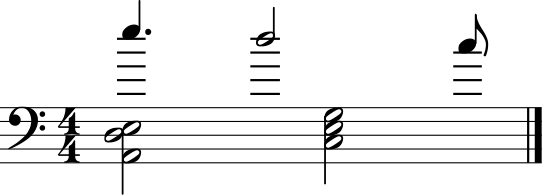

In [19]:
seed_item.show()

Here's what the seed sounds like:

In [20]:
seed_item.play()

### Start Predictions:

In [21]:
pred = learn.predict(seed_item, n_words=100)

Seed - used for prediction

Prediction

In [22]:
pred.data

array([ 72, 138,  52, 139, ..., 139,   8, 139,   8])

In [28]:
pred.data.reshape([-1,2])

array([[ 72, 138],
       [ 52, 139],
       [ 81, 138],
       [ 65, 153],
       ...,
       [138,   8],
       [141,  55],
       [139,   8],
       [139,   8]])

In [30]:
pred.to_npenc()

Non midi note detected. Only returning valid portion. Index, seed 17 (50, 2)


array([[63,  1],
       [43,  2],
       [72,  1],
       [56, 16],
       [-1, 16],
       [-1,  8],
       [-1,  2],
       [55,  2],
       [56, 16],
       [-1,  1],
       [55,  1],
       [52,  1],
       [-1,  6],
       [48,  2],
       [-1,  1],
       [75,  1],
       [72,  1]])

Non midi note detected. Only returning valid portion. Index, seed 17 (50, 2)


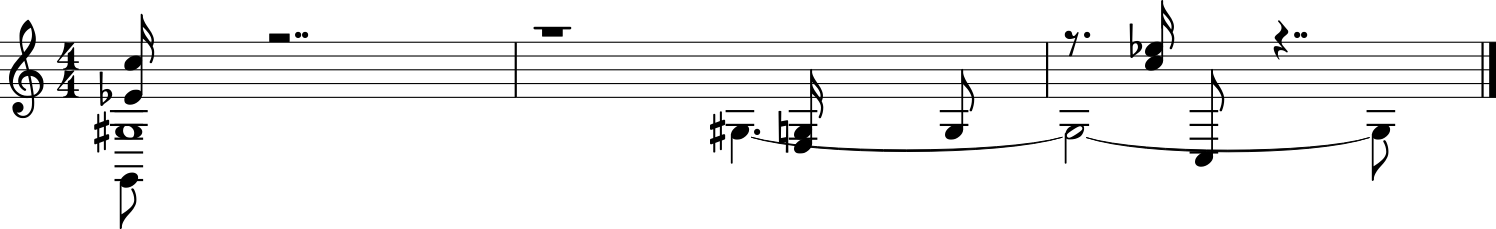

In [31]:
# Prediction
pred.show()

In [32]:
pred.play()